In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import WOEEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

sns.set_style('whitegrid') # sets the visual style of Seaborn plots to 'whitegrid', which displays a white background with grid lines.
sns.set_palette('pastel')  # sets the color palette to 'pastel', which is one of the predefined color palettes provided by Seaborn. It consists of a set of visually distinct colors suitable for plotting categorical data.

import warnings
# Ignore all warnings
warnings.simplefilter("ignore")

In [2]:
train_df = pd.read_csv('fraudTrain.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('fraudTest.csv', index_col='Unnamed: 0')

In [3]:
train_df.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop               

In [5]:
train_df.shape

(1296675, 22)

In [6]:
is_fraud = train_df["is_fraud"].value_counts()
print("Yes: ",is_fraud[1])
print("No: ",is_fraud[0])

Yes:  7506
No:  1289169


In [7]:
print(train_df.isna().sum().sum())
print(train_df.duplicated().sum())

0
0


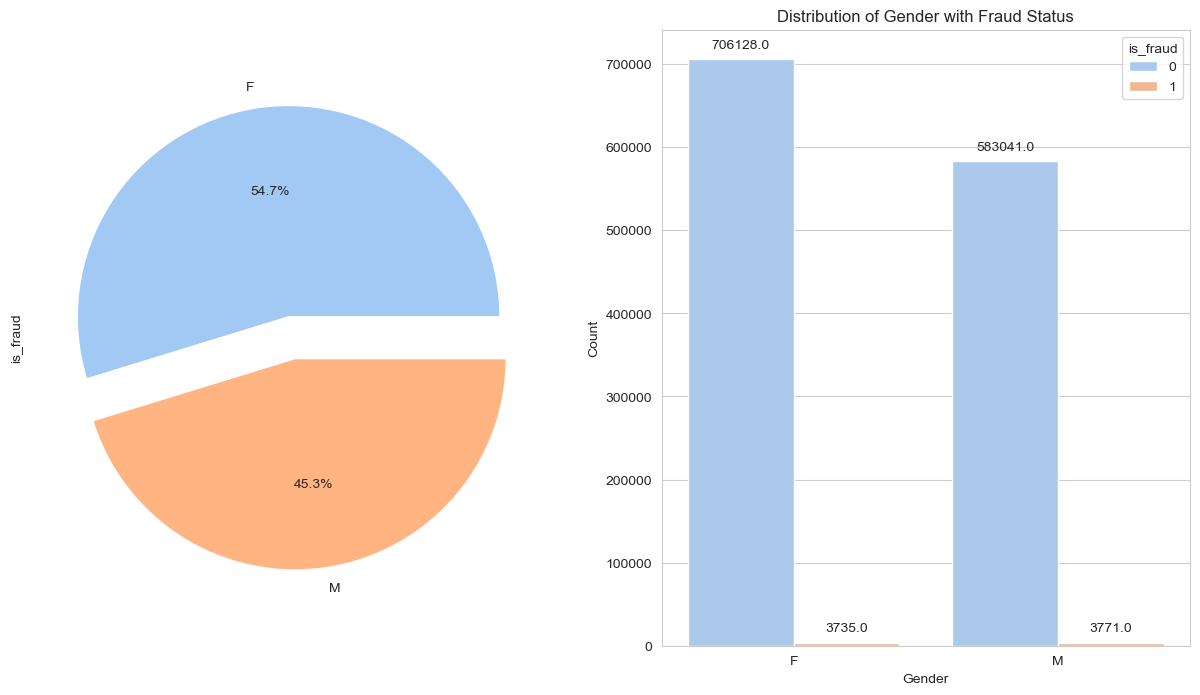

In [8]:
fig,axb = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))

#Gender Distribution
explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().plot.pie(explode=explode, autopct="%1.1f%%",ax=axb[0]);

ax = sns.countplot(x="gender", hue="is_fraud", data=train_df,ax=axb[1])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.title("Distribution of Gender with Fraud Status")
plt.xlabel("Gender")
plt.ylabel("Count")

# Show the plot
plt.show()

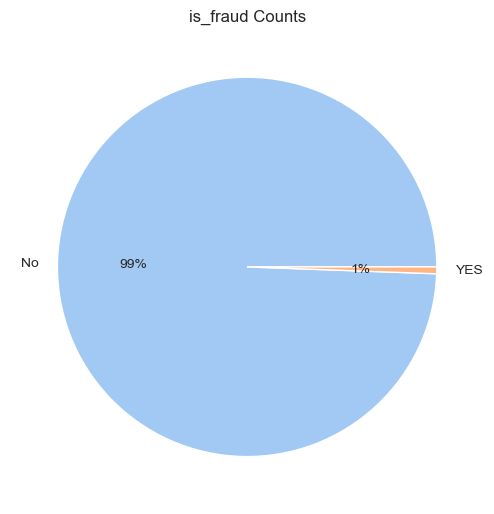

In [9]:
is_fraud = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [10]:
#Change date type from obj to datetime
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'],format='mixed')
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'],format='mixed')

In [11]:
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

train_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,month
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1


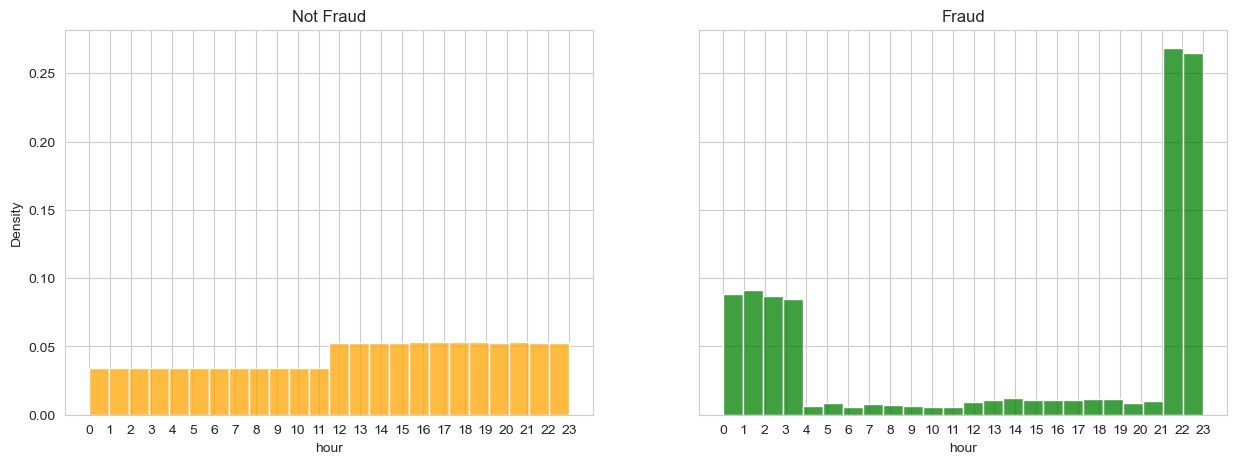

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

ax1 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1, color="orange")

ax2 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="green")

ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

ax1.set_xticks(np.arange(24)) # ticks of the day 0 -> 23
ax2.set_xticks(np.arange(24));

In [13]:
unique_transaction_count = len(train_df['trans_num'].unique())
print("Total count of unique transaction numbers:", unique_transaction_count)

Total count of unique transaction numbers: 1296675


In [14]:
# remove non-useful columns
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,0,1
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,0,1


In [15]:
#clean merchant column
train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 14 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   merchant    1296675 non-null  object 
 1   category    1296675 non-null  object 
 2   amt         1296675 non-null  float64
 3   last        1296675 non-null  object 
 4   gender      1296675 non-null  object 
 5   lat         1296675 non-null  float64
 6   long        1296675 non-null  float64
 7   city_pop    1296675 non-null  int64  
 8   job         1296675 non-null  object 
 9   merch_lat   1296675 non-null  float64
 10  merch_long  1296675 non-null  float64
 11  is_fraud    1296675 non-null  int64  
 12  hour        1296675 non-null  int32  
 13  month       1296675 non-null  int32  
dtypes: float64(5), int32(2), int64(2), object(5)
memory usage: 138.5+ MB


In [17]:
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,"Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,0,1
1,"Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,0,1


In [18]:
train_df.describe(include='object')

,merchant,category,last,gender,job
count,1296675,1296675,1296675,1296675,1296675
unique,693,14,481,2,494
top,Kilback LLC,gas_transport,Smith,F,Film/video editor
freq,4403,131659,28794,709863,9779


In [19]:
# applying label encoding
train_df['gender'] = train_df['gender'].map({'F': 0, 'M': 1})

# applying WOE encoding
for col in ['job','merchant', 'category', 'lat', 'last']:
    train_df[col] = WOEEncoder().fit_transform(train_df[col],train_df['is_fraud'])

In [20]:
train_df.head(3)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,0.959326,0.924914,4.97,-2.469513,0,36.0788,-81.1781,3495,-1.080186,36.011293,-82.048315,0,0,1
1,0.663187,0.898799,107.23,-0.673638,0,48.8878,-118.2105,149,-0.904144,49.159047,-118.186462,0,0,1
2,-0.790166,-0.847622,220.11,0.433257,1,42.1808,-112.2620,4154,1.120434,43.150704,-112.154481,0,0,1


In [21]:
from sklearn.preprocessing import StandardScaler


In [22]:
No_class = train_df[train_df["is_fraud"]==0]
yes_class = train_df[train_df["is_fraud"]==1]

No_class = resample(No_class, replace=False, n_samples=len(yes_class))
down_samples = pd.concat([yes_class, No_class], axis=0)


X = down_samples.drop("is_fraud", axis=1)
y = down_samples["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

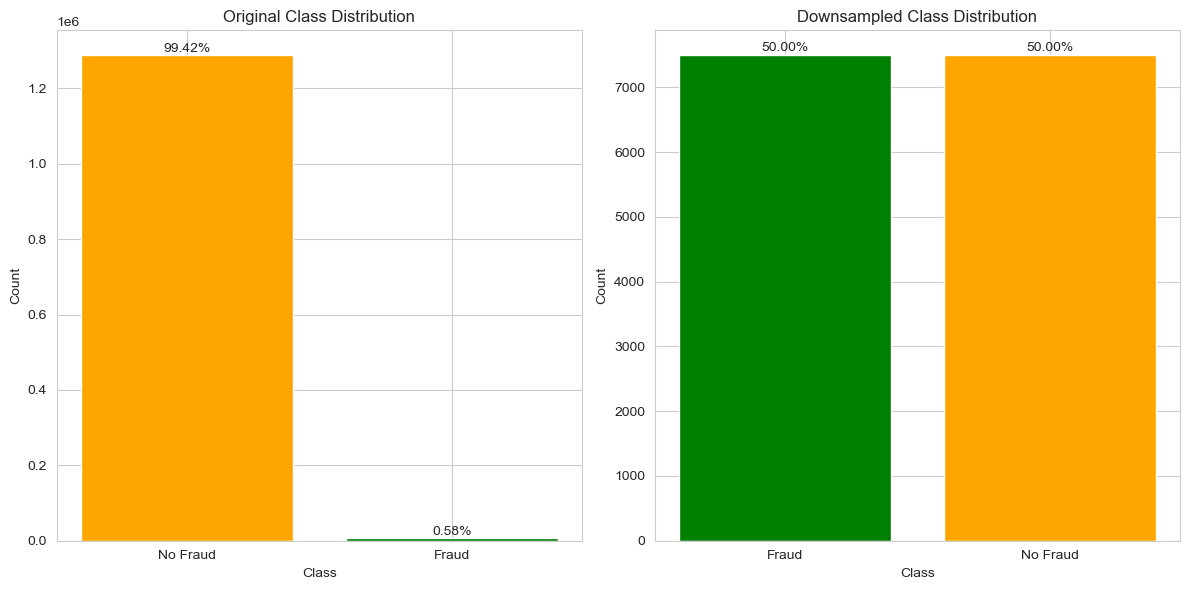

In [23]:
# Count the occurrences of each class in the original dataset
original_class_counts = train_df["is_fraud"].value_counts()

# Count the occurrences of each class in the downsampled dataset
downsampled_class_counts = down_samples["is_fraud"].value_counts()

# Calculate the percentage of each class
original_percentages = original_class_counts / len(train_df) * 100
downsampled_percentages = downsampled_class_counts / len(down_samples) * 100

# Plotting
plt.figure(figsize=(12, 6))

# Bar chart for original class distribution
plt.subplot(1, 2, 1)
bars_1 = plt.bar(original_class_counts.index, original_class_counts.values, color=['orange', 'green'])
for bar, label in zip(bars_1, original_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(original_class_counts.index, ['No Fraud', 'Fraud'])

# Bar chart for downsampled class distribution
plt.subplot(1, 2, 2)
bars_2 = plt.bar(downsampled_class_counts.index, downsampled_class_counts.values, color=['orange', 'green'])
for bar, label in zip(bars_2, downsampled_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Downsampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(downsampled_class_counts.index, ['No Fraud', 'Fraud'])

plt.tight_layout() # the plots will be automatically adjusted to ensure that there is no overlap between subplots and that all elements are clearly visible.
plt.show()

In [24]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
predict_LR = LR_model.predict(X_test)
print(classification_report(y_test, predict_LR))
LR_accuracy = accuracy_score(predict_LR,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LR_accuracy*100))

              precision    recall  f1-score   support

           0       0.79      0.93      0.86      1486
           1       0.92      0.76      0.83      1517

    accuracy                           0.85      3003
   macro avg       0.86      0.85      0.84      3003
weighted avg       0.86      0.85      0.84      3003

Logistic Regression accuracy is: 84.55%


In [25]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
predict = svm_model.predict(X_test)

print(classification_report(y_test, predict))
svm_accuracy = accuracy_score(predict,y_test)
print('SVC model accuracy is: {:.2f}%'.format(svm_accuracy*100))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1486
           1       0.93      0.74      0.83      1517

    accuracy                           0.84      3003
   macro avg       0.85      0.84      0.84      3003
weighted avg       0.86      0.84      0.84      3003

SVC model accuracy is: 84.12%


In [26]:
# Create and train the Gaussian Naive Bayes model
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_naive = NB_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_naive))
GaussianNB_accuracy = accuracy_score(y_pred_naive, y_test)
print('Naive Bayes model accuracy is: {:.2f}%'.format(GaussianNB_accuracy * 100))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1486
           1       0.90      0.74      0.81      1517

    accuracy                           0.83      3003
   macro avg       0.84      0.83      0.82      3003
weighted avg       0.84      0.83      0.82      3003

Naive Bayes model accuracy is: 82.52%


In [27]:
DT = DecisionTreeClassifier(max_depth=(1), random_state=0)
DT.fit(X_train, y_train)
predict_ID3 = DT.predict(X_test)
print(classification_report(y_test, predict_ID3))
ID3_accuracy = accuracy_score(predict_ID3,y_test)
print('ID3 model accuracy is: {:.2f}%'.format(ID3_accuracy*100))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1486
           1       0.97      0.74      0.84      1517

    accuracy                           0.86      3003
   macro avg       0.88      0.86      0.85      3003
weighted avg       0.88      0.86      0.85      3003

ID3 model accuracy is: 85.55%


In [28]:
# Initialize and train the Random Forest classifier
RF = RandomForestClassifier(n_estimators=100, random_state=0)
RF.fit(X_train, y_train)

predict_RF = RF.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predict_RF))
RF_accuracy = accuracy_score(predict_RF, y_test)
print('Random Forest model accuracy is: {:.2f}%'.format(RF_accuracy * 100))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1486
           1       0.97      0.96      0.97      1517

    accuracy                           0.97      3003
   macro avg       0.97      0.97      0.97      3003
weighted avg       0.97      0.97      0.97      3003

Random Forest model accuracy is: 96.60%


In [29]:
# Initialize and train the XGBoost classifier
XGB = XGBClassifier(random_state=0)
XGB.fit(X_train, y_train)

# Make predictions on the test set
predict_XGB = XGB.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predict_XGB))
XGB_accuracy = accuracy_score(predict_XGB, y_test)
print('XGBoost model accuracy is: {:.2f}%'.format(XGB_accuracy * 100))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1486
           1       0.98      0.98      0.98      1517

    accuracy                           0.98      3003
   macro avg       0.98      0.98      0.98      3003
weighted avg       0.98      0.98      0.98      3003

XGBoost model accuracy is: 98.14%


In [30]:
Algorithms = ['XGBClassifier', 'RandomForest', 'ID3', 'Logistic Regression', 'SVC', 'GaussianNB']
accuracy = [XGB_accuracy, RF_accuracy, ID3_accuracy, LR_accuracy, svm_accuracy, GaussianNB_accuracy]

FinalResult=pd.DataFrame({'Algorithm':Algorithms, 'Accuracy':accuracy})

FinalResult

,Algorithm,Accuracy
0,XGBClassifier,0.981352
1,RandomForest,0.966034
2,ID3,0.855478
3,Logistic Regression,0.845488
4,SVC,0.841159
5,GaussianNB,0.825175


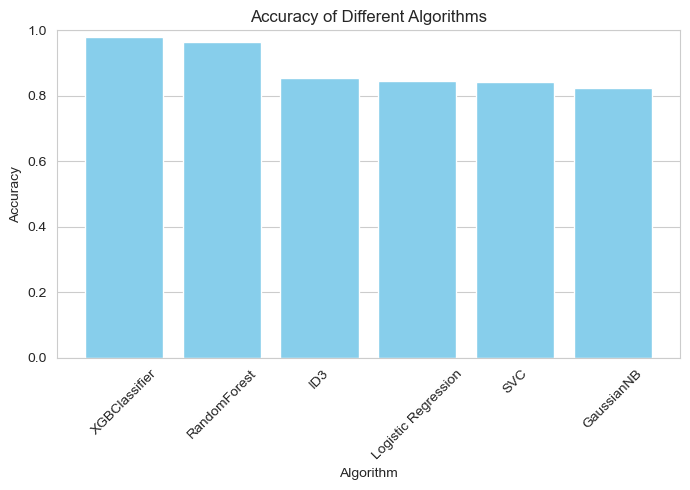

In [31]:
plt.figure(figsize=(7, 5))
plt.bar(FinalResult['Algorithm'], FinalResult['Accuracy'], color='skyblue')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Algorithms')
plt.ylim(0, 1)  # Set the limit of y-axis from 0 to 1 (accuracy ranges from 0 to 1)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='x')  # Add gridlines only along the x-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()